In [2]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ && cd /root/NVIDIA_CUDA-11.2_Samples/

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-r379rjpv
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-r379rjpv
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=72724cc0ea1cc317d7e6aae5f450b5ea8c9255ee0483a12e1d2824e4ad03370a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9t4rhtl2/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out
/bin/bash: line 1: cuda-install-s

In [45]:
%%cuda --name lab_2.cu
#include <cublas_v2.h>
#include <malloc.h>
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <cstdlib>
#include <curand.h>
#include <stdio.h>
#include <time.h>
#include <iostream>
#include <ctime>
#pragma comment (lib, "cublas.lib")
cudaError_t addWithCuda(double*c, const double*a, const double*b, unsigned int size);
__global__ void addKernel(double*c, const double *a, const double*b, unsigned int size) {
  int index = blockIdx.x * blockDim.x + threadIdx.x;
  while (index < size) {
    c[index] = a[index] + b[index];
    index += blockDim.x * gridDim.x;
  }
}

void print_vector(double* vec, int size) {
  for (int i = 0; i < size; i++) {
    if (i > 3 && i != size -1 && size > 4)
      continue;
    printf("%f", vec[i]);
    if (i != size - 1 && i != 3) {
        printf(", ");
        continue;
    }
    if (i == 3 && size > 3) {
      printf(" ... ");
    }
  }
}

void sum_vec(double*c_check, const double*a, const double*b, unsigned int size) {
    for (int i = 0; i < size; i++) {
        c_check[i] = a[i] + b[i];
    }
}

int main(int argc, char* argv[])
{
  int n;
  std::cin >> n;
  int GRID_SIZE = 1024;
  int BLOCK_SIZE = 512;
  printf("n = %d \n", n);
  int n2b = n * sizeof(double);
  int n2 = n;
  // Выделение памяти на хосте
  double* a = (double*)malloc(n2 * sizeof(double));
  double* b = (double*)malloc(n2 * sizeof(double));
  double* c = (double*)malloc(n2 * sizeof(double));
  double* c_check = (double*)malloc(n2 * sizeof(double));
  // Инициализация массивов
  for (int i = 0; i < n; i++) {
    a[i] = (double)rand()/RAND_MAX;
    b[i] = (double)rand()/RAND_MAX;
    c[i] = (double)rand()/RAND_MAX;
  }
  // Выделение памяти на устройстве
  double* adev = NULL;
  cudaError_t cuerr = cudaMalloc((void**)&adev, n2b);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot allocate device array for a: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  double* bdev = NULL;
  cuerr = cudaMalloc((void**)&bdev, n2b);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot allocate device array for b: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  double* cdev = NULL;
  cuerr = cudaMalloc((void**)&cdev, n2b);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot allocate device array for c: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  // Создание обработчиков событий
  cudaEvent_t start, stop;
  float gpuTime = 0.0f;
  cuerr = cudaEventCreate(&start);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot create CUDA start event: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  cuerr = cudaEventCreate(&stop);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot create CUDA end event: %s\n", cudaGetErrorString(cuerr));
  return 0;
  }
  // Копирование данных с хоста на девайс
  cuerr = cudaMemcpy(adev, a, n2b, cudaMemcpyHostToDevice);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot copy a array from host to device: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  cuerr = cudaMemcpy(bdev, b, n2b, cudaMemcpyHostToDevice);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot copy b array from host to device: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  // Установка точки старта
  cuerr = cudaEventRecord(start, 0);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot record CUDA event: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }

  //Запуск ядра
  addKernel <<< GRID_SIZE, BLOCK_SIZE >>> (cdev, adev, bdev, n);
  cuerr = cudaGetLastError();
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot launch CUDA kernel: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  // Синхронизация устройств
  cuerr = cudaDeviceSynchronize();
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot synchronize CUDA kernel: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  // Установка точки окончания
  cuerr = cudaEventRecord(stop, 0);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot copy c array from device to host: %s\n",cudaGetErrorString(cuerr));
    return 0;
  }
  // Копирование результата на хост
  cuerr = cudaMemcpy(c, cdev, n2b, cudaMemcpyDeviceToHost);
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot copy c array from device to host: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }


  // Расчет времени
  cuerr = cudaEventElapsedTime(&gpuTime, start, stop);
  printf("Parameters: (%d, %d)\n", GRID_SIZE, BLOCK_SIZE);
  printf("Time GPU: %.9f seconds\n", gpuTime / 1000);

  clock_t time_cpu;
  time_cpu = clock();
  //Сложение векторов CPU
  sum_vec(c_check, a, b, n);
  time_cpu = clock() - time_cpu;
  printf("Time CPU: %.9f \n", (double) time_cpu / CLOCKS_PER_SEC);


  printf("A = ");
  print_vector(a, n);
  printf("\nB = ");
  print_vector(b, n);
  printf("\nC = ");
  print_vector(c, n);
  printf("\ncheck = ");
  print_vector(c_check, n);

  // Очищение памяти
  cudaEventDestroy(start);
  cudaEventDestroy(stop);
  cudaFree(adev);
  cudaFree(bdev);
  cudaFree(cdev);
  free(a);
  free(b);
  free(c);
  return 0;
}

'File written in /content/src/lab_2.cu'

In [46]:
!nvcc -o /content/src/lab_2 /content/src/lab_2.cu -lcurand -lcublas

In [51]:
!/content/src/lab_2

10000000
n = 10000000 
Parameters: (1024, 512)
Time GPU: 0.000964256 seconds
Time CPU: 0.063228000 
A = 0.840188, 0.798440, 0.335223, 0.553970 ... 0.383011
B = 0.394383, 0.911647, 0.768230, 0.477397 ... 0.139840
C = 1.234571, 1.710087, 1.103452, 1.031367 ... 0.522850
check = 1.234571, 1.710087, 1.103452, 1.031367 ... 0.522850

Таблица с результатами эксаперимета:

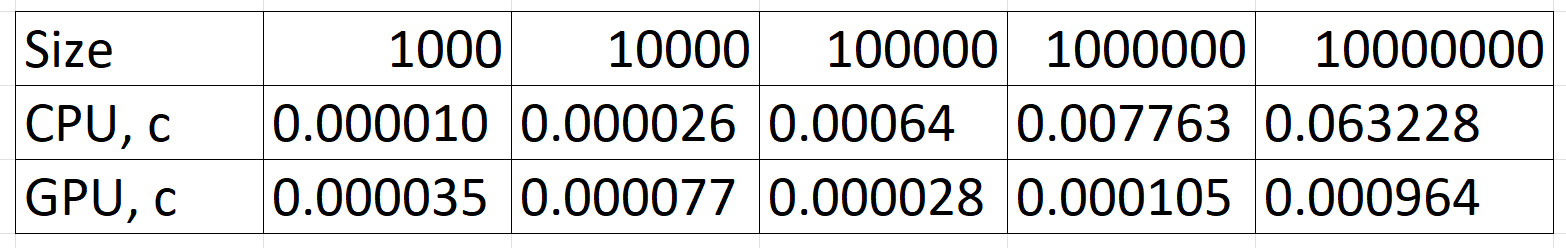

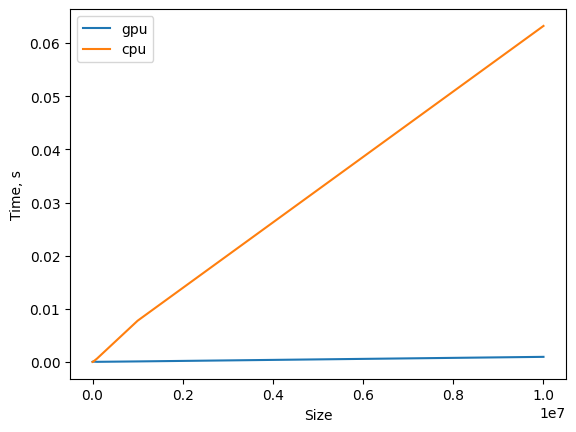

In [56]:
import matplotlib.pyplot as plt
x = [1000, 10000, 100000, 1000000, 10000000]
cpu = [0.000010, 0.000026, 0.00064, 0.007763, 0.063228]
gpu = [0.000035, 0.000077, 0.000028, 0.000105, 0.000964]
plt.xlabel("Size")
plt.ylabel("Time, s")
plt.plot(x, gpu, label='gpu')
plt.plot(x, cpu, label='cpu')
plt.legend()
plt.show()

Для вычисления ускорения параллельной программы относительно последовательной необходимо найти отношение времени работы последовательного алгоритма к времени исполнения параллельного алгоритма.

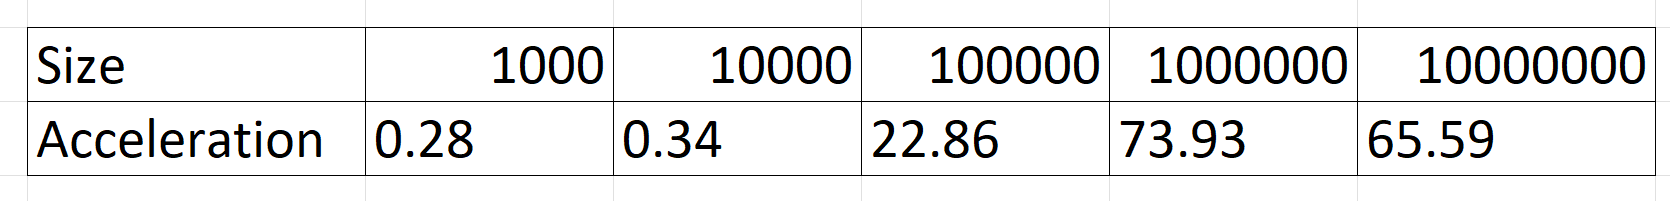

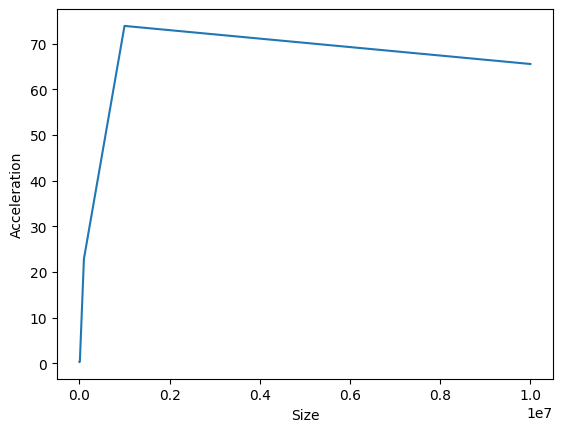

[0.28571428571428575, 0.3376623376623376, 22.857142857142858, 73.93333333333332, 65.58921161825727]


In [58]:
a = [cpu[i] / gpu[i] for i in range(len(cpu))]
plt.xlabel("Size")
plt.ylabel("Acceleration")
plt.plot(x, a)
plt.show()
print(a)

Исходя из полученных результатов,
можно сделать вывод о том, что ускорение алгоритма прямо
пропорционально размерности суммируемых векторов (чем больше
размерность, тем больше ускорение). Зависимость ускорения программ от
параметров GridDim и BlockDim проследить трудно. Однако отметим, что
решение создания нитей больше, чем размерность векторов, не является
оптимальным (поскольку часть нитей не выполняет работу по суммированию
элементов). Наиболее хороший результат показывает выбор параметров
таким образом, чтобы число нитей было наиболее близко к размерности
векторов.